https://medium.com/att-israel/use-a-very-good-speech-recognition-model-with-pytorch-89ecc126ef7b

In [1]:
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

In [2]:
SPEECH_URL = "https://keithito.com/LJ-Speech-Dataset/LJ025-0076.wav"
SPEECH_FILE = "_assets/speech.wav"
if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

In [3]:
IPython.display.Audio(SPEECH_FILE)

Now, let’s import the pre-trained Wav2Vec2 model.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample Rate: {bundle.sample_rate}")
print(f"Labels: {bundle.get_labels()}")
model = bundle.get_model().to(device)
print(model.__class__)

Using device cpu
Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:04<00:00, 78.1MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


Ha empezado a descargar el modelo a las 10:37. Ha terminado a las 10:58

Now we would like to get the **waveform** of the speech file. The waveform is **a digital representation of the speech file’s** acoustic signal, and we get it (**as a Tensor**) by calling torchaudio.load. If necessary, we then resample the waveform — just like the processing device, the speech data’s sample rate (the number of audio samples per second) must match that of the model for the model to work properly.

In [5]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
print(waveform.shape)
print(type(waveform))

torch.Size([1, 134347])
<class 'torch.Tensor'>


We are going to get the actual labels from the waveform, that is: we will run the model to classify the speech frames (a “frame” is the smallest unit of speech).

In [6]:
with torch.inference_mode():
    emission, _ = model(waveform)
print(emission.shape)
print(type(emission))

torch.Size([1, 419, 29])
<class 'torch.Tensor'>


In [7]:
print(emission)
print(len(emission))
print(len(emission[0]))
print(len(emission[0][0]))
print(emission[0][418][:])
print(emission[0][418][0])

tensor([[[14.4887, -2.2472, -1.9805,  ..., -6.9065, -7.8924, -7.7348],
         [14.6138,  0.2476, -1.6581,  ..., -6.8786, -8.3551, -7.4920],
         [ 2.5793, -1.3902, -1.2736,  ..., -2.7316, -4.1375, -4.4695],
         ...,
         [14.2213, -3.6237, -2.2180,  ..., -6.7184, -6.6961, -7.8266],
         [14.2231, -3.3926, -2.2200,  ..., -6.7321, -6.8063, -7.8330],
         [14.5681, -2.6291, -2.2642,  ..., -7.0087, -7.2261, -8.0398]]])
1
419
29
tensor([14.5681, -2.6291, -2.2642, -1.8095, -0.1366, -3.0686, -1.3474, -2.1014,
        -0.7475, -2.5094, -3.5784, -3.1354, -3.5932, -2.8247, -4.6184, -2.4289,
        -5.8535, -5.7364, -5.1261, -4.2215, -5.2814, -3.2678, -5.0777, -6.6536,
        -8.5636, -8.1898, -7.0087, -7.2261, -8.0398])
tensor(14.5681)


Let’s plot the results, just to visualize the model’s logits, or unnormalized predictions. They are essentially probabilities that are not limited to [0,1] — they can be any real number, i.e. in the range (-∞,∞).

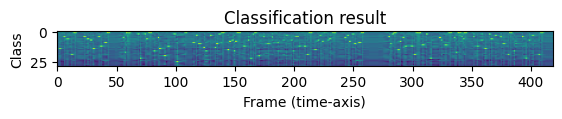

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [8]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

The classifications are currently encoded — they are just the label logits. To decode them, that is, to actually get the transcribed text, we will define a greedy CTC decoder. The CTC algorithm is very good for speech recognition.

In [20]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
        emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
        str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1) # [num_seq,]
        print(indices.tolist())
        indices = torch.unique_consecutive(indices, dim=-1)
        print(indices.tolist())
        indices = [i for i in indices if i != self.blank]
        print(indices)
        return "".join([self.labels[i] for i in indices])

And then, you know, instantiate it and decode the classifications to get the transcript:

In [21]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

[0, 0, 14, 0, 0, 0, 4, 0, 6, 6, 0, 0, 19, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 6, 0, 7, 7, 14, 14, 0, 0, 0, 4, 12, 12, 0, 0, 9, 9, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 17, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 22, 0, 0, 0, 2, 6, 6, 1, 1, 1, 0, 0, 16, 0, 0, 5, 14, 14, 0, 0, 20, 20, 0, 12, 12, 0, 0, 0, 0, 2, 25, 25, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 9, 0, 3, 0, 10, 10, 0, 0, 0, 13, 16, 16, 0, 0, 3, 0, 0, 0, 13, 10, 10, 2, 2, 1, 1, 1, 0, 0, 0, 15, 8, 8, 0, 7, 16, 8, 8, 1, 1, 1, 0, 0, 12, 12, 0, 0, 7, 0, 22, 0, 2, 0, 1, 0, 0, 20, 0, 0, 0, 4, 0, 0, 10, 10, 0, 0, 4, 0, 0, 0, 0, 9, 0, 0, 0, 0, 7, 0, 3, 0, 0, 0, 7, 0, 16, 0, 4, 4, 4, 12, 0, 0, 0, 12, 12, 0, 19, 1, 1, 1, 0, 0, 15, 15, 0, 7, 0, 3, 8, 8, 0, 0, 0, 7, 6, 6, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 3, 8, 0, 0, 2, 0, 10, 0, 0, 9, 9, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 10, 2, 2, 1, 1, 0, 15, 15, 8, 0, 0, 5, 12, 12, 0, 0, 0, 12, 12, 0, 19, 19, 1, 1, 1, 1, 0, 11, 0, 0, 2, 2, 0, 22, 22

In [11]:
print(transcript)

MANY|ANIMALS|OF|EVEN|COMPLEX|STRUCTURE|WHICH|LIVE|PARASITICALLY|WITHIN|OTHERS|ARE|WHOLLY|DEVOID|OF|AN|ALIMENTARY|CAVITY|


He creado un archivo mp3 y lo voy a probar

In [13]:
pip install pydub

In [14]:
from os import path
from pydub import AudioSegment

In [15]:
TESTING_FILE = "_assets/peter_london.mp3"
IPython.display.Audio(TESTING_FILE)

ValueError: ignored

In [ ]:
sound = AudioSegment.from_mp3('peter_london.mp3')
sound.export('wav_form.wav', format="wav")
IPython.display.Audio('wav_form.wav')

In [ ]:
waveform, sample_rate = torchaudio.load('wav_form.wav')
waveform = waveform.to(device)
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
print(waveform.shape)
print(type(waveform))

torch.Size([2, 93696])
<class 'torch.Tensor'>


In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)
print(emission.shape)
print(type(emission))

torch.Size([2, 292, 29])
<class 'torch.Tensor'>


In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
print(transcript)

PETER|LIFE|IN|LONDON|


Conclusión: Mi inglés es muy malo. Hay que joderse pero la RNN tiene razon. He dicho 'life' en vez de 'lives'